In [11]:
from sklearn.mixture import GaussianMixture

import pandas as pd
import numpy as np

import os
import sys

# Add the parent directory to the system path
module_path = os.path.abspath(os.getcwd() + '\\..')
if module_path not in sys.path:
    sys.path.append(module_path)
    
from helpers.ConditionalGMM.condGMM import CondGMM

def generate_gmm(n_samples):
    weights = np.array([0.3, 0.4, 0.3])  # Mixing weights for each component
    n_components = 3  # Number of components

    # Mean vectors for each Gaussian component
    means = [np.array([0, 0]), np.array([2, 2]), np.array([-2, -2])]

    # Covariance matrices for each component
    covariances = []
    for _ in range(n_components):
        rand_mat = np.random.rand(2, 2)
        cov = np.dot(rand_mat, rand_mat.T)  # Ensure the matrix is symmetric and positive-definite
        covariances.append(cov)

    # Sample from each component
    samples = []
    for i in range(n_components):
        num_samples_component = int(weights[i] * n_samples)  # Number of samples for this component
        samples_component = np.random.multivariate_normal(means[i], covariances[i], num_samples_component)
        samples.append(samples_component)

    # Combine the samples from all components
    samples_np = np.vstack(samples)

    return samples_np, weights, means, covariances

N = 400
my_seed = 1
np.random.seed(my_seed)
samples_np, weights, means, covariances = generate_gmm(N)
gmm = GaussianMixture(n_components=3, random_state=my_seed)
gmm.fit(samples_np)


GaussianMixture(n_components=3, random_state=1)

(400,)
(1,)


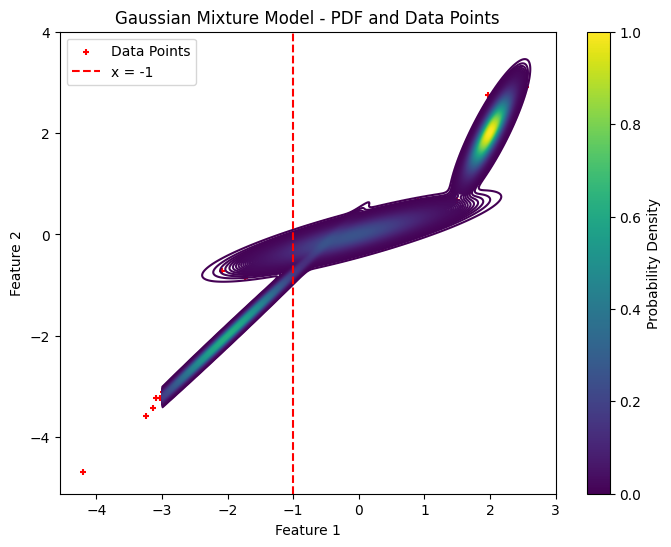

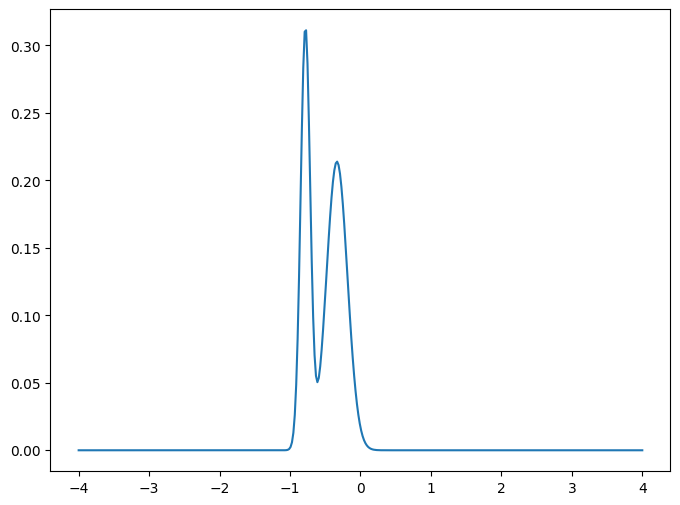

In [12]:
import matplotlib.pyplot as plt
# Create a grid of points where we will evaluate the PDF
x = np.linspace(-3, 3, 400)
y = np.linspace(-4, 4, 400)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T

# Calculate the PDF values at grid points
log_pdf = gmm.score_samples(XX)
pdf = np.exp(log_pdf).reshape(X.shape)
plt.figure(figsize=(8, 6))

# Plot the contour lines for the PDF
plt.contour(X, Y, pdf, levels=np.linspace(np.min(pdf), np.max(pdf), 500), cmap='viridis')

# Plotting the original data
plt.scatter(samples_np[:, 0], samples_np[:, 1], s=15, marker='+', color = 'red', label='Data Points')

plt.axvline(x=-1, color='red', linestyle='--', label='x = -1')


plt.colorbar(label='Probability Density')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Gaussian Mixture Model - PDF and Data Points')
plt.legend()

plt.figure(figsize=(8, 6))
print(x.shape)

x_frozen = -1*np.ones((1,))
print(x_frozen.shape)
XF, YF = np.meshgrid(x_frozen, y)
XXF = np.array([XF.ravel(), YF.ravel()]).T

log_pdf_F = gmm.score_samples(XXF)
pdf_F = np.exp(log_pdf_F).reshape(XF.shape)

plt.plot(y, pdf_F)
plt.show()

In [13]:

def cgmm_impute(gmm, missing_features_indices, current_row, number_of_samples):
    """
    Impute missing values using Conditional GMM, returning parameters of the predictive distribution.
    
    Parameters:
        gmm (GMM): Gaussian Mixture Model.
        missing_features_indices (list): Indices of missing features.
        current_row (pandas.Series): Current row with missing values.
        number_of_samples (int): Number of samples to generate.
        
    Returns:
        dict: A dictionary containing samples, means ('mu'), and covariances ('sigma').
    """
    # Find indices of known features
    known_features_indices = [i for i in range(len(current_row)) if i not in missing_features_indices]
    
    # Extract values of known features for the given row
    known_features_values = current_row.iloc[known_features_indices].values
    
    # Initialize CondGMM
    cGMM = CondGMM(gmm.weights_, gmm.means_, gmm.covariances_, known_features_indices)
    
    # Generate samples using Conditional GMM
    generated_samples = cGMM.rvs(known_features_values, size=number_of_samples, random_state=RANDOM_STATE)
    
    # Make sure that the generated samples do not contain NaN values, if it does then change it's value to 0
    generated_samples[np.isnan(generated_samples)] = 0
    
    # Extract mean and covariance for the conditional distribution
    mus = cGMM.conditional_component_means(known_features_values)
    c_weights = cGMM.conditional_weights(known_features_values)
    c_weights = c_weights[:, np.newaxis]  # Ensure weights are aligned for broadcasting
    mu = np.sum(c_weights * mus, axis=0)  # Weighted sum across the correct axis
    sigma = cGMM.conditional_component_covs()

    return {
        "samples": generated_samples,
        "mu": mu,
        "sigma": sigma
    }


In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


shape of temporary obj: (388,)
shape of temporary obj: (612,)
[[-0.25780799]
 [-0.33677704]
 [-0.73282739]
 [-0.80376604]
 [-0.7268271 ]
 [-0.72911613]
 [-0.88079297]
 [-0.79229745]
 [-0.78810373]
 [-0.28024582]
 [-0.47973484]
 [-0.44939715]
 [-0.79793224]
 [-0.05237306]
 [-0.83292246]
 [-0.33595764]
 [-0.43974704]
 [-0.12925797]
 [-0.65674396]
 [-0.76772748]
 [-0.35751092]
 [-0.43023954]
 [-0.67677509]
 [-0.5494368 ]
 [-0.218435  ]
 [-0.49556552]
 [-0.82031851]
 [-0.8536099 ]
 [-0.77292066]
 [-0.41427848]
 [-0.81991899]
 [-0.23854507]
 [-0.30693921]
 [-0.34705191]
 [-0.36599883]
 [-0.62034   ]
 [-0.16400749]
 [-0.00294695]
 [-0.76527269]
 [-0.41572344]
 [-0.24971409]
 [-0.04772555]
 [-0.70396897]
 [-0.17393989]
 [-0.79701053]
 [-0.43623142]
 [-0.39818472]
 [-0.80389154]
 [-0.78394637]
 [-0.75781939]
 [-0.72444546]
 [-0.42303238]
 [-0.79011222]
 [-0.82786699]
 [-0.46989059]
 [-0.85402075]
 [-0.4268848 ]
 [-0.7870392 ]
 [-0.29531776]
 [-0.4214075 ]
 [-0.74313872]
 [-0.20407073]
 [-0.315

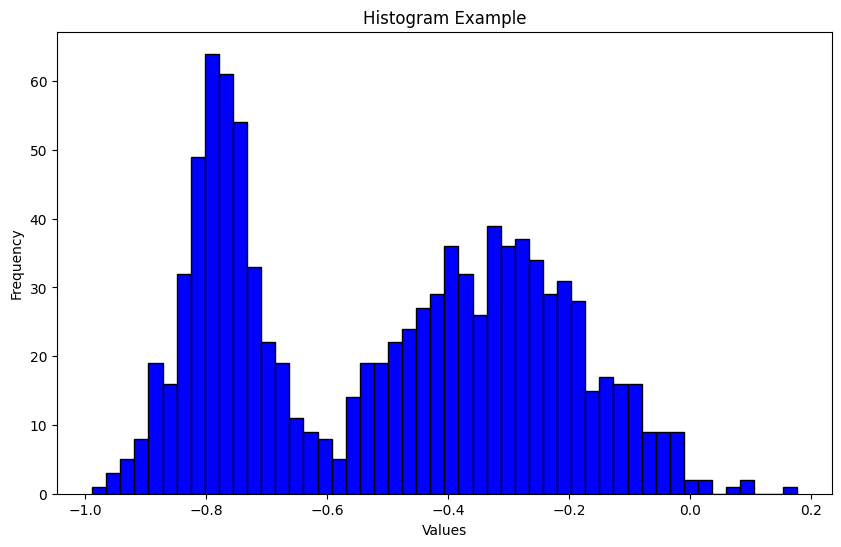

In [15]:
RANDOM_STATE = my_seed
imputed_values = cgmm_impute(gmm, [1], pd.DataFrame([-1, np.nan]), 1000)

plt.figure(figsize=(10, 6))  # Set the figure size
plt.hist(imputed_values['samples'], bins=50, color='blue', edgecolor='black')  # Bins define the number of bars

print(imputed_values['samples'])

# Customizing the histogram
plt.title('Histogram Example')  # Title of the histogram
plt.xlabel('Values')  # Label for the x-axis
plt.ylabel('Frequency')  # Label for the y-axis

# Show the plot
plt.show()